## Author: Muhammad

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pycaret.regression import *

**Data Source:** Census Bureau America Community Survery 2018, 5 Year Estimates, [hosted on Google BigQuery](https://console.cloud.google.com/marketplace/product/united-states-census-bureau/acs?filter=solution-type:dataset&project=covid-disparities&organizationId=0)

In [ ]:
acs = pd.read_csv("/work/COVIDRedlining/data/ACS/acs_census_tract_2018_5yr.csv")
acs.drop(columns=["Unnamed: 0", "do_date"], inplace=True)

## Feature Engineering for ACS Variables

In [ ]:
# Filtering columns which contain population numbers
male_female_columns = [x for x in acs.columns 
                    if "male_" in x and 
                    x not in ['male_male_households', 'female_female_households','children_in_single_female_hh']
]
pop_columns = [x for x in acs.columns if "pop" in x] + male_female_columns

### Aggregating Various Variables

In [ ]:
list(acs.columns)

['geo_id',
 'total_pop',
 'households',
 'male_pop',
 'female_pop',
 'median_age',
 'male_under_5',
 'male_5_to_9',
 'male_10_to_14',
 'male_15_to_17',
 'male_18_to_19',
 'male_20',
 'male_21',
 'male_22_to_24',
 'male_25_to_29',
 'male_30_to_34',
 'male_35_to_39',
 'male_40_to_44',
 'male_45_to_49',
 'male_50_to_54',
 'male_55_to_59',
 'male_60_to_61',
 'male_62_to_64',
 'male_65_to_66',
 'male_67_to_69',
 'male_70_to_74',
 'male_75_to_79',
 'male_80_to_84',
 'male_85_and_over',
 'female_under_5',
 'female_5_to_9',
 'female_10_to_14',
 'female_15_to_17',
 'female_18_to_19',
 'female_20',
 'female_21',
 'female_22_to_24',
 'female_25_to_29',
 'female_30_to_34',
 'female_35_to_39',
 'female_40_to_44',
 'female_45_to_49',
 'female_50_to_54',
 'female_55_to_59',
 'female_60_to_61',
 'female_62_to_64',
 'female_65_to_66',
 'female_67_to_69',
 'female_70_to_74',
 'female_75_to_79',
 'female_80_to_84',
 'female_85_and_over',
 'white_pop',
 'population_1_year_and_over',
 'population_3_years_o

In [ ]:
# Create 4 new SVI variables from ACS variables 
acs['aged_65_or_older'] = acs['female_65_to_66'] + acs['female_67_to_69'] + acs['female_70_to_74'] + acs['female_75_to_79'] + acs['female_80_to_84'] + acs['female_85_and_over'] + acs['male_65_to_66'] + acs['male_67_to_69'] + acs['male_70_to_74'] + acs['male_75_to_79'] + acs['male_80_to_84'] + acs['male_85_and_over']
acs['aged_17_or_younger'] = acs['female_under_5'] + acs['female_5_to_9'] + acs['female_10_to_14'] + acs['female_15_to_17'] + acs['male_under_5'] + acs['male_5_to_9'] + acs['male_10_to_14'] + acs['male_15_to_17']
acs['multi_unit_structures'] = acs['dwellings_10_to_19_units'] + acs['dwellings_20_to_49_units'] + acs['dwellings_50_or_more_units']

In [ ]:
# # Function for converting percentile bins into categories
# def perc_bin(x):
    
#     if x > 0 and x <= 0.1:
#       val = 1
#     elif x > 0.1 and x <= 0.2:
#       val = 2
#     elif x > 0.2 and x <= 0.3:
#       val = 3
#     elif x > 0.3 and x <= 0.4:
#       val = 4
#     elif x > 0.4 and x <= 0.5:
#       val = 5
#     elif x > 0.5 and x <= 0.6:
#       val = 6
#     elif x > 0.6 and x <= 0.7:
#       val = 7
#     elif x > 0.7 and x <= 0.8:
#       val = 8
#     elif x > 0.8 and x <= 0.9:
#       val = 9
#     elif x > 0.9 and x <= 1:
#       val = 10
#     else:
#       val = 0

#     return val

In [ ]:
# Aggregating variables and normalising them
acs['poverty_perc'] = acs['poverty']/acs['pop_determined_poverty_status']
# acs['unemployed_pop_perc'] = acs['unemployed_pop'] / acs['total_pop'] # Moved down
acs['less_than_high_school_graduate_perc'] = acs['less_than_high_school_graduate'] / acs['total_pop']
acs['aged_65_or_older_perc'] = acs['aged_65_or_older'] / acs['total_pop']
acs['aged_17_or_younger_perc'] = acs['aged_17_or_younger'] / acs['total_pop']
acs['one_parent_families_with_young_children_perc'] = \
    acs['one_parent_families_with_young_children'] / acs['households']
acs['multi_unit_structures_perc'] = acs['multi_unit_structures'] / acs['housing_units']
acs['mobile_homes_perc'] = acs['mobile_homes'] / acs['housing_units'] 
acs['group_quarters_perc'] = acs['group_quarters'] / acs['total_pop']
# TODO: no_cars needs to be moved down
acs['no_cars_perc'] = acs['no_cars'] / acs['households']

In [ ]:
# Dropping all the columns whose data has been aggregated or normalised
acs.drop(columns=
    [
        'female_65_to_66', 'female_67_to_69', 'female_70_to_74', 'female_75_to_79', 'female_80_to_84', 
        'female_85_and_over','male_65_to_66', 'male_67_to_69', 'male_70_to_74', 'male_75_to_79', 
        'male_80_to_84', 'male_85_and_over', 'poverty', 'pop_determined_poverty_status', 
        'less_than_high_school_graduate', 'aged_65_or_older', 'aged_17_or_younger', 
        'one_parent_families_with_young_children', 'multi_unit_structures', 'mobile_homes', 
        'group_quarters', 
    ], inplace=True)
# Removed unemployed_pop, no_cars, non_white from list

In [ ]:
# Other Races in the Original Data is overriden by other_races_pop = total_pop - sum(races),
# where races is shown below.
races = ['black_pop',
 'asian_pop',
 'hispanic_pop',
 'amerindian_pop',
 'white_pop']
acs['other_race_pop_perc'] = (acs.total_pop - acs[races].sum(axis=1)) / acs.total_pop

# Non-white
acs['non_white_pop'] = acs['total_pop'] - acs['white_pop']

# Normalising racial populations by total_pop
acs['black_pop_perc'] = acs.black_pop / acs.total_pop
acs['asian_pop_perc'] = acs.asian_pop / acs.total_pop
acs['hispanic_pop_perc'] = acs.hispanic_pop / acs.total_pop
acs['amerindian_pop_perc'] = acs.amerindian_pop / acs.total_pop
acs['white_pop_perc'] = acs.white_pop / acs.total_pop
acs['non_white_pop_perc'] = acs.non_white_pop / acs.total_pop

# Dropping raw populations in favour of normalised percentages
acs.drop(columns=['two_or_more_races_pop', 'non_white_pop', 'other_race_pop'] + races, inplace=True)

In [ ]:
columns_to_drop = [
    ## Already accounted for in pop cleaning above
    'hispanic_any_race', 'not_hispanic_pop',

    ## Breakdown of pop by sexes
    'male_under_5', 'male_5_to_9', 'male_10_to_14', 'male_15_to_17', 'male_18_to_19', 'male_20',
    'male_21', 'male_22_to_24', 'male_25_to_29', 'male_30_to_34', 'male_35_to_39', 'male_40_to_44',
    'male_45_to_49', 'male_50_to_54', 'male_55_to_59', 'male_60_to_61', 'male_62_to_64', 'female_under_5',
    'female_5_to_9', 'female_10_to_14', 'female_15_to_17', 'female_18_to_19', 'female_20', 'female_21',
    'female_22_to_24', 'female_25_to_29', 'female_30_to_34', 'female_35_to_39', 'female_40_to_44',
    'female_45_to_49', 'female_50_to_54', 'female_55_to_59', 'female_60_to_61', 'female_62_to_64',
    
    ## Breakdown of pop by age
    'population_1_year_and_over', 'population_3_years_over', 'pop_5_years_over', 'pop_15_and_over',
    'pop_16_over', 'pop_25_years_over', 'pop_25_64', 
    
    ## Breakdown of pop by age + race
    'asian_male_45_54', 'asian_male_55_64', 'black_male_45_54', 'black_male_55_64', 'hispanic_male_45_54',
    'hispanic_male_55_64', 'white_male_45_54', 'white_male_55_64', 
    
    ## Dwellings
    'dwellings_1_units_detached', 'dwellings_1_units_attached', 'dwellings_2_units', 'dwellings_3_to_4_units', 
    'dwellings_5_to_9_units', 'dwellings_10_to_19_units', 'dwellings_20_to_49_units', 
    'dwellings_50_or_more_units', 
    
    ## Moved Houses
    'different_house_year_ago_different_city', 'different_house_year_ago_same_city',
    
    ## Degrees + male + age
    'male_45_64_associates_degree', 'male_45_64_bachelors_degree', 'male_45_64_graduate_degree',
    'male_45_64_less_than_9_grade', 'male_45_64_grade_9_12', 'male_45_64_high_school', 'male_45_64_some_college',
    'male_45_to_64',
    
    ## Type of employment
    'employed_agriculture_forestry_fishing_hunting_mining',
    'employed_arts_entertainment_recreation_accommodation_food', 'employed_construction',
    'employed_education_health_social', 'employed_finance_insurance_real_estate', 'employed_information',
    'employed_manufacturing', 'employed_other_services_not_public_admin', 'employed_public_administration',
    'employed_retail_trade', 'employed_science_management_admin_waste',
    'employed_transportation_warehousing_utilities', 'employed_wholesale_trade', 'occupation_management_arts',
    'occupation_natural_resources_construction_maintenance', 'occupation_production_transportation_material',
    'occupation_sales_office', 'occupation_services', 'sales_office_employed',
    
    ## Types of Student Populations, normalise by total_pop
    'in_grades_1_to_4', 'in_grades_5_to_8', 'in_grades_9_to_12', 'in_school', 'in_undergrad_college',
    
    ## Language spoken at home
    'speak_only_english_at_home', 'speak_spanish_at_home', 'speak_spanish_at_home_low_english',
]

In [ ]:
unsure = [
    'housing_units', 'renter_occupied_housing_units_paying_cash_median_gross_rent',
    'owner_occupied_housing_units_lower_value_quartile', 'owner_occupied_housing_units_median_value',
    'owner_occupied_housing_units_upper_value_quartile', 'occupied_housing_units',
    'housing_units_renter_occupied', 'vacant_housing_units', 'vacant_housing_units_for_rent',
    'vacant_housing_units_for_sale', 
    
    ## Same-sex couples?
    'male_male_households', 'female_female_households',
    
    ## Family Structure
    'families_with_young_children', 'two_parent_families_with_young_children',
    'two_parents_in_labor_force_families_with_young_children',
    'two_parents_father_in_labor_force_families_with_young_children',
    'two_parents_mother_in_labor_force_families_with_young_children',
    'two_parents_not_in_labor_force_families_with_young_children',
    'father_one_parent_families_with_young_children',
    'father_in_labor_force_one_parent_families_with_young_children',
    
    ## Rent burdens may be relevant to sociecomic factors. Grouped into high/low burden? Threshold?
    'rent_burden_not_computed', 'rent_over_50_percent', 'rent_40_to_50_percent', 'rent_35_to_40_percent',
    'rent_30_to_35_percent', 'rent_25_to_30_percent', 'rent_20_to_25_percent', 'rent_15_to_20_percent',
    'rent_10_to_15_percent', 'rent_under_10_percent',
    
    ## Commute times, would need to be normalised by commuters_16_over
    'commute_less_10_mins', 'commute_10_14_mins', 'commute_15_19_mins', 'commute_20_24_mins',
    'commute_25_29_mins', 'commute_30_34_mins', 'commute_35_44_mins', 'commute_60_more_mins',
    'commute_45_59_mins', 'commuters_16_over', 'walked_to_work', 'worked_at_home',
    'aggregate_travel_time_to_work',
    'no_car', #All people in a geographic area over the age of 16 who do not own a car
    
    ## Number of cars, normalise by households
    'no_cars', 'one_car', 'two_cars', 'three_cars', 'four_more_cars',
    
    ## Commute Method, normalise by commuters_16_over
    'commuters_by_public_transportation', 'commuters_by_bus', 'commuters_by_car_truck_van',
    'commuters_by_carpool', 'commuters_by_subway_or_elevated', 'commuters_drove_alone',
    
    ## Degrees and Education, normalise by total_pop
    'associates_degree', 'bachelors_degree', 'high_school_diploma', 'less_one_year_college', 'masters_degree',
    'one_year_more_college', 'high_school_including_ged', 'bachelors_degree_2', 'graduate_professional_degree',
    'some_college_and_associates_degree',
    
    ## Group into high/low income? Threshold? Normalise by households
    'income_less_10000', 'income_10000_14999', 'income_15000_19999', 'income_20000_24999', 'income_25000_29999',
    'income_30000_34999', 'income_35000_39999', 'income_40000_44999', 'income_45000_49999',
    'income_50000_59999', 'income_60000_74999', 'income_75000_99999', 'income_100000_124999',
    'income_125000_149999', 'income_150000_199999', 'income_200000_or_more',
]

In [ ]:
divide_by_total_pop = ['pop_never_married', 'pop_now_married', 'pop_separated', 'pop_widowed',
    'pop_divorced', 'not_us_citizen_pop', 'children', 'male_pop', 'female_pop',
    'children_in_single_female_hh', # divide by 'children' instead?
]

divide_by_housing_units = [
    'housing_built_2005_or_later', 'housing_built_2000_to_2004', 'housing_built_1939_or_earlier',
]

divide_by_households = [
    ## Family Structure
    'married_households', 'nonfamily_households', 'family_households', 
    
    ## Public Assistance
    'households_public_asst_or_food_stamps',
    
    ## House ownership stats
    'million_dollar_housing_units', 'mortgaged_housing_units', 'owner_occupied_housing_units',

]

list_normalise = [
    ('total_pop', divide_by_total_pop),
    ('housing_units', divide_by_housing_units),
    ('households', divide_by_households)
]

In [ ]:
divide_by_pop_16_over = [
    'employed_pop', # normalise by pop_in_labor_force instead?
    'unemployed_pop', # same as above
]

# Indicator of high-paying jobs
divide_by_civilian_labor_force = [
    'management_business_sci_arts_employed',
]

list_normalise += [
    ('pop_16_over', divide_by_pop_16_over),
    ('civilian_labor_force', divide_by_civilian_labor_force)
]

# To drop or not?
columns_to_drop += [
    'workers_16_and_over', 'armed_forces', 'civilian_labor_force', 'pop_in_labor_force', 'not_in_labor_force',
]

In [ ]:
# [var for (divisor, vars) in list_normalise for var in vars if var not in acs.columns]

In [ ]:
def normalise_variable(variable: str, divisor: str):
    """
    Normalises a given column of a acs dataframe by a divisor, adds _perc to the column name, 
    and then deletes the origingal column
    """
    acs[variable + '_perc'] = acs[variable] / acs[divisor]
    acs.drop(columns=variable, inplace=True)


for divisor, l in list_normalise:
    for var in l:
        normalise_variable(var, divisor)

acs.drop(columns=columns_to_drop + unsure, inplace=True)

In [ ]:
list(acs.columns)

['geo_id',
 'total_pop',
 'households',
 'median_age',
 'median_income',
 'income_per_capita',
 'gini_index',
 'median_year_structure_built',
 'median_rent',
 'percent_income_spent_on_rent',
 'bachelors_degree_or_higher_25_64',
 'poverty_perc',
 'less_than_high_school_graduate_perc',
 'aged_65_or_older_perc',
 'aged_17_or_younger_perc',
 'one_parent_families_with_young_children_perc',
 'multi_unit_structures_perc',
 'mobile_homes_perc',
 'group_quarters_perc',
 'no_cars_perc',
 'other_race_pop_perc',
 'black_pop_perc',
 'asian_pop_perc',
 'hispanic_pop_perc',
 'amerindian_pop_perc',
 'white_pop_perc',
 'non_white_pop_perc',
 'pop_never_married_perc',
 'pop_now_married_perc',
 'pop_separated_perc',
 'pop_widowed_perc',
 'pop_divorced_perc',
 'not_us_citizen_pop_perc',
 'children_perc',
 'male_pop_perc',
 'female_pop_perc',
 'children_in_single_female_hh_perc',
 'housing_built_2005_or_later_perc',
 'housing_built_2000_to_2004_perc',
 'housing_built_1939_or_earlier_perc',
 'married_househ

## Geo (Redlining) Data

In [ ]:
%%bash
pwd

/home/jovyan


In [ ]:
# Reading the goe_files for each city.
geo_files = [
"/work/COVIDRedlining/data/dallas/dallas_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/detroit/detroit_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/new york/ny_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/minneapolis/minneapolis_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/california/cali_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/tampa/tampa_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/newark/newark_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/chicago/chicago_redlined_numerical_values.geojson",
"/work/COVIDRedlining/data/atlanta/atlanta_redlined_numerical_values.geojson",
]

dfs = [gpd.read_file(x) for x in geo_files]

In [ ]:
# Shows the number of rows per city
num_rows = [len(x) for x in dfs]
city_names = [x.split("_", 1)[0].split("/")[-1] for x in geo_files]
# Number of data points for each city
for x in zip(city_names, num_rows):
    print(x)

('dallas', 122)
('detroit', 573)
('ny', 2122)
('minneapolis', 124)
('cali', 2146)
('boston', 196)
('tampa', 60)
('newark', 224)
('chicago', 1033)
('atlanta', 135)


In [ ]:
# Rounding off the reweighted_redline_index to 2 decimal places to reduce spurious variability
# i.e., 3.1111 and 3.1156 are not different enough to be consider very different
geo_intersect = pd.DataFrame(pd.concat(dfs))
geo_intersect = geo_intersect[["GEOID", "reweighted_redline_index","ordinal_value"]]
geo_intersect['reweighted_redline_index'] = geo_intersect['reweighted_redline_index'].round(2)
geo_intersect

,GEOID,reweighted_redline_index,ordinal_value
0,4.811398e+10,3.10,4
1,4.811300e+10,2.09,3
2,4.811301e+10,1.00,1
3,4.811300e+10,2.16,3
4,4.811301e+10,3.00,3
...,...,...,...
130,1.312101e+10,3.00,3
131,1.312101e+10,2.46,3
132,1.312101e+10,2.00,2
133,1.308902e+10,3.00,3


In [ ]:
# A check for catching outliers with respect to the reweighted_redline_index
# np.unique(geo_intersect.reweighted_redline_index, return_counts=True)[0]
geo_intersect[geo_intersect.reweighted_redline_index < 1]

,GEOID,reweighted_redline_index,ordinal_value
258,3.608112e+10,0.16,1
1713,3.608112e+10,0.81,1
1727,3.608113e+10,0.00,1
2,6.037181e+09,0.78,1
231,6.037461e+09,0.56,1
257,6.001405e+09,0.62,1
297,6.037128e+09,0.00,1
750,6.085503e+09,0.63,1
852,6.037128e+09,0.93,1
861,6.037129e+09,0.41,1


# Joining ACS and Redlining Data

In [ ]:
# Merging the geo_files and the ACS data
joined = geo_intersect.merge(acs, how="inner", left_on="GEOID", right_on="geo_id")
joined.drop(columns=["GEOID", "ordinal_value", "geo_id"], inplace=True)

In [ ]:
# Writing the result to file
joined.to_csv("/work/COVIDRedlining/ACS/output/acs_feature_data.csv")

In [ ]:
joined = pd.read_csv("acs_feature_data.csv")

FileNotFoundError: [Errno 2] File acs_feature_data.csv does not exist: 'acs_feature_data.csv'

In [ ]:
# Number of unique redlining index values
len(np.unique(joined.reweighted_redline_index.values.round(2)))

322

In [ ]:
exp1 = setup(joined, target = "reweighted_redline_index")

,Description,Value
0,session_id,2576
1,Target,reweighted_redline_index
2,Original Data,"(6735, 233)"
3,Missing Values,True
4,Numeric Features,222
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4714, 210)"


In [ ]:
# MAE = Mean Absolute Error
# MSE = Mean Squared Error
# RMSE = Root Mean Squared Error
# R2 = R-Squared
# RMLSE = Root Mean Squared Logarithmic Error
# MAPE = Mean Absolute Percentage Error
# TT = Time Taken For Computation
compare_models(optimise="R2")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4395,0.3181,0.5638,0.4554,0.1606,0.2502,36.0770
lightgbm,Light Gradient Boosting Machine,0.4500,0.3309,0.5750,0.4332,0.1632,0.2532,1.8220
et,Extra Trees Regressor,0.4588,0.3413,0.5839,0.4158,0.1659,0.2610,6.5960
gbr,Gradient Boosting Regressor,0.4640,0.3468,0.5887,0.4065,0.1669,0.2593,5.2530
rf,Random Forest Regressor,0.4672,0.3506,0.5918,0.3996,0.1677,0.2598,14.6100
xgboost,Extreme Gradient Boosting,0.4732,0.3712,0.6090,0.3645,0.1714,0.2629,4.7850
br,Bayesian Ridge,0.4841,0.3822,0.6177,0.3451,0.1728,0.2684,0.0990
en,Elastic Net,0.4839,0.3824,0.6180,0.3448,0.1730,0.2679,0.2430
lasso,Lasso Regression,0.4886,0.3882,0.6227,0.3351,0.1746,0.2709,0.2860
omp,Orthogonal Matching Pursuit,0.4948,0.3969,0.6297,0.3201,0.1755,0.2682,0.0320


In [ ]:
cat = create_model("catboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4421,0.3385,0.5818,0.4295,0.1717,0.2085
1,0.4342,0.3156,0.5617,0.4458,0.1612,0.3567
2,0.4432,0.3160,0.5622,0.4486,0.1581,0.1823
3,0.4553,0.3282,0.5729,0.4063,0.1531,0.1709
4,0.4462,0.3347,0.5785,0.4613,0.1678,0.1770
5,0.4545,0.3235,0.5688,0.4214,0.1619,0.2984
6,0.4402,0.3106,0.5573,0.4915,0.1559,0.1957
7,0.4325,0.3275,0.5723,0.4750,0.1729,0.5544
8,0.4056,0.2790,0.5282,0.5157,0.1552,0.1905
9,0.4411,0.3072,0.5542,0.4584,0.1483,0.1677


In [ ]:
tuned_cat = tune_model(cat)

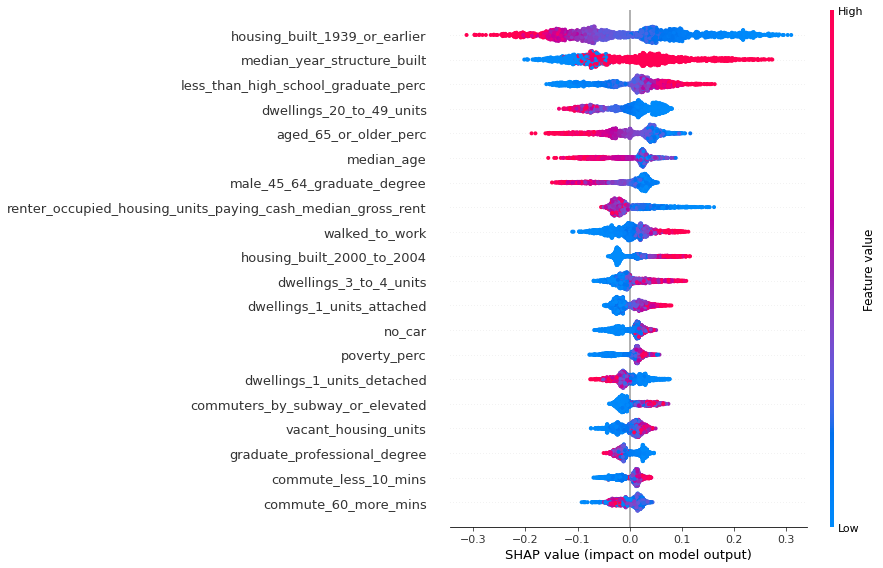

In [ ]:
interpret_model(cat)

# Interpreting Shapley Values

Please see these [four short videos](https://www.coursera.org/lecture/ai-for-medical-treatment/individual-feature-importance-TnfPK) for a better understanding of Shapley values. You will, unfortunately, need to create a Coursera account, because they only let you watch three videos without an account.

In summary, though, each point in the above graph represents a single sample.This is what sets Shapley values apart from 'global' feature importance methods, because it shows you the importance of each feature on a per-sample basis.

The colour of the point shows the value of the feature for that sample. So, for the `median_age` column, a red value means the census tract had a higher median age, while a blue point indicates that the tract had a lower median age.

The x-axis, meanwhile, shows the contribution of that particular feature on the prediction for that particular sample. A positive value on the x-axis indicates a positive contribution toward the predicted value (i.e., an increase in the predicted value) compared to the mean of the overall population, while a negative value on the x-axis indicates a decrease in the predicted value compared to the mean of the overall population. 

This is the *other useful thing* about Shapley values, because **they not only indicate how important a particular feature is, but also what effect a higher/lower feature value has on the prediction** (i.e., does it increase/decrease the predicted value).

Putting it all together, if we consider the `median_age`, what the above graph, with red points being clustered around the left and the blue points clustered around the right, shows is that when a census tract has a higher median age (i.e., red points), this is likely to make the redlining index value of the census tract to decrease.

Note that the way Akash set it up, an index value of 1.0 corresponds to the highest grade (A), while a value of 5.0 corresponds to the lowest grade (E).

As such, the fact that a higher `median_age` corresponds to a lower index value means that **the higher the median age of the census tract, the more likely that it has a good grade (e.g., an A)**, and vice versa.

This could be explained by, perhaps, considering the fact that older people are more likely to be better off economically, and therefore more likely to live in a good neighbourhood, which would result in a better redlining grade. Alternatively, it is sometimes the case that people with lower incomes have more children on average (not sure if this is the case in the U.S., but it is sometimes the case in less developed countries). As such, lower income neighbourhood = more children per capita = lower median age.

These are, of course, just some guesses on my part. The true reason for the correlation would require further research.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>